В данном файле рассмотрена задача классификации изображений на основен данных FashionMNIST.
Набор данных состоит из черно-белых изображений 28x28 пикселей, на которых изображены элементы одежды.
Каждое изображение принадлежит одному из 10 классов.

Ниже прописан импорт библиотек.
1. torch: Библиотека для глубокого обучения. Она предоставляет поддержку для тензоров и автоматически вычисляет градиенты.
2. torch.nn: Подмодуль библиотеки PyTorch, который содержит классы для создания нейронных сетей. Он предоставляет различные слои, функции активации и другие компоненты, необходимые для построения моделей.
3. torch.utils.data: Этот модуль помогает в обработке данных. Класс Dataset используется для определения пользовательских наборов данных, а DataLoader позволяет эффективно загружать данные пакетами.
4. torchvision: Это библиотека включает в себя функции для обработки изображений, а также предобученные модели и наборы данных.
5. numpy: Библиотека для работы с массивами и матрицами, а также для выполнения различных математических операций.
6. sklearn.model_selection: Этот модуль из библиотеки Scikit-learn предоставляет функцию train_test_split для разделения данных на обучающую и тестовую выборки.
7. torchvision.transforms: Подмодуль, который содержит различные трансформации для обработки изображений, такие как изменение размера, поворот, обрезка и нормализация.
8. tqdm: Библиотека для отображения прогресс-баров в циклах. Полезна для отслеживания прогресса длительных операций (например, при обучении модели).
9. torchviz: Библиотека для визуализации графов вычислений PyTorch.
10. matplotlib.pyplot: Библиотека для создания графиков и визуализации данных.

In [49]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm import tqdm
from torchviz import make_dot
import matplotlib.pyplot as plt

Ниже загружаются две выборки FashionMNIST (набор данных для задач классификации изображений, состоящий из изображений одежды).
Обучающая выборка train_dataset (train = true) и тестовая выборка test_dataset (train = False).
В каждом наборе изображения переводятся в формат тензоров (transforms.ToTensor()).
Выборки загружаются в папку /data текущего каталога.

In [50]:
#transform = transforms.ToTensor()
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Добавлена нормализация данных
])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root = "./data", train = False, download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:06<00:00, 3894532.28it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 705979.30it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:02<00:00, 2023867.67it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 5035512.36it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



Ниже создаются объекты train_loader, test_loader - загрузчики данных для обучающей и тестовой выборки.
batch_size определяет какой пакет данных будет выдаваться в каждой итерации (64 образца), shuffle=False запрещает перемешивать данные.

In [51]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Ниже из обучающей и тестовой выборок извлекается один пакет (батч) данных.
Т.е. в train_item, test_item лежат тензоры с изображениями и названиями (len(train_item) == 2, len(test_item) == 2).
train_item[0].shape == torch.Size([64, 1, 28, 28]), значит каждый батч содержит 64 черно-белых изображения размера 28x28.
train_item[1].shape == torch.Size([64]), значит каждый батч содержит 64 названия.

In [52]:
train_item = next(iter(train_loader))
test_item = next(iter(test_loader))
len(train_item), len(test_item), train_item[0].shape, train_item[1].shape

(2, 2, torch.Size([64, 1, 28, 28]), torch.Size([64]))

Ниже определяется класс нейронной сети на базе класса torch.nn.Module

In [53]:
class NNModel(nn.Module):
    def __init__(self,
                 # Размеры слоев изменены в соответствие с размерами данных
                 layers_size = [784, 32, 16, 10], 
                 dropout_prob = 0.1 # Вероятность отключения нейрона изменена с 1.0 до 0.1
                 ):
        super().__init__()
        self.conv = nn.Conv2d(1, 1, kernel_size = 1, stride = 1)
        # Для линейных слоев использован ModuleList
        self.layers = nn.ModuleList( [nn.Linear(layers_size[i], layers_size[i+1]) for i in range(len(layers_size)-1)] )
        self.norm = [nn.BatchNorm1d(inp_size, affine  = False) for inp_size in layers_size[1:-1]]
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, batch):
        bs = batch.shape[0]
        batch = self.conv(batch)  # Применение свёрточного слоя
        batch = batch.view(bs, -1)
        # Применение линейных слоев
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) -1:
                batch = self.dropout(self.relu(self.norm[i](layer(batch))))
            else:
                batch = layer(batch)
        return batch

    def print_net(self): # Вывод структуры сети
        print(self.conv)
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) -1:
                print(layer)
                print(self.norm[i])
                print(self.relu)
                print(self.dropout)
            else:
                print(layer)

        return

Ниже создается экземпляр класса и печатается его структура.

In [54]:
mlp  = NNModel()

# predictions = mlp(train_item[0])
# make_dot(predictions, params=dict(mlp.named_parameters()))
mlp.print_net()

Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
Linear(in_features=784, out_features=32, bias=True)
BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
Dropout(p=0.1, inplace=False)
Linear(in_features=32, out_features=16, bias=True)
BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
Dropout(p=0.1, inplace=False)
Linear(in_features=16, out_features=10, bias=True)


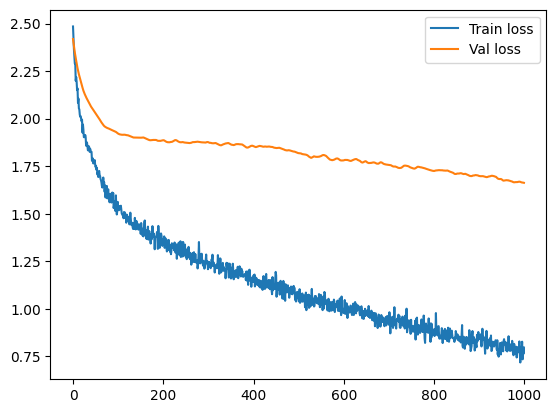

In [55]:
num_epochs = 1000
DEBUG = False
ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr =  0.0001) # Уменьшена скорость обучения

logger = {'train':[],
          'eval' :[]
          }
for epoch in range(num_epochs):

    epoch_stat = []

    # train part

    mlp.train()
    for batch in [train_item]:

        images, labels = batch
        images, labels = images.float(), labels.long()
        
        optimizer.zero_grad() # Добавлено обнуление градиентов перед вычислениями
        predictions = mlp(images)
        loss = ce_loss(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_stat.append(loss.item())

    if DEBUG: print(f"train loss value = {np.mean(epoch_stat)}")
    logger['train'].append(np.mean(epoch_stat))

    # eval part
    eval_stat = [] # eval stat был вынесен из цикла
    mlp.eval() # Добавлен вызов mlp.eval()
    with torch.no_grad():
        # Для тестирования модели теперь используется отдельная выборка
        for batch in [test_item]:

            images, labels = batch
            images, labels = images.float(), labels.long()

            predictions = mlp(images)
            loss = ce_loss(predictions, labels)
            # На этапе тестирования модели было выключено обновление параметров
            #loss.backward() 
            #optimizer.step()

            eval_stat.append(loss.item())
        if DEBUG: print(f"eval loss value = {np.mean(eval_stat)}")
        logger['eval'].append(np.mean(eval_stat))

plt.plot(logger['train'], label='Train loss' )
plt.plot(logger['eval'], label='Val loss')
plt.legend()
plt.show()

In [56]:
mlp

NNModel(
  (conv): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
# pytorch_total_params = sum(p.numel() for p in mlp.parameters())
# pytorch_total_params